# Simulated NLP codes

**Code checklist:** <br/>
√ parallel computing
<br/>√ preprocessing: tokenisation, lemmanisation etc  (for stop word   won? not?)
<br/>√ LDA model
<br/>√ Doc2Vec model
<br/>√ LSA model
<br/>√ Dictionary based method
<br/>√ word2Vec model


# Section 1: Data Sources 

In [94]:
import pandas as pd
import string
import matplotlib.pyplot as plt
from datetime import datetime

en_stop_words = set(stopwords.words('english'))
list(en_stop_words)[:10]
df_tweets = pd.read_json('trump.txt')
df_tweets.head()

,text,created_at
0,RT @HeshmatAlavi: @realDonaldTrump Mr. Preside...,2020-05-23 18:10:16+00:00
1,RT @thejtlewis: @realDonaldTrump President Tru...,2020-05-23 18:09:18+00:00
2,RT @kathystrube_com: @Lrihendry @realDonaldTru...,2020-05-23 18:08:54+00:00
3,"RT @Lrihendry: @realDonaldTrump May 20th, 2020...",2020-05-23 18:08:50+00:00
4,Who are the 4%? A RINO or two! https://t.co/fY...,2020-05-23 12:55:04+00:00


In [3]:
doc1 = "Sugar is bad to consume. My sister likes to have sugar, but not my father."
doc2 = "My father spends a lot of time driving my sister around to dance practice."
doc3 = "Doctors suggest that driving may cause increased stress and blood pressure."
doc4 = "Sometimes I feel pressure to perform well at school, but my father never seems to drive my sister to do better."
doc5 = "Health experts say that Sugar is not good for your lifestyle."
# compile documents
consersation = [doc1, doc2, doc3, doc4, doc5]

doc1 = 'The repo rate path that provides the basis for the forecasts in the draft Monetary Policy Report assumes continued rate rises during the forecast period, but at a slower pace compared to February. A slight postponement of the next rise feels natural in light of the somewhat lower inflation forecast, especially this year.'
doc2 = 'Developments since April have been largely as we expected, and it is now proposed that the repo-rate path is held unchanged, with slow increases in the repo rate during the forecast period.'
doc3 = 'The very expansionary monetary policy was never intended to last forever. Now when inflation is around 2 per cent, monetary policy is slowly going in a less expansionary direction, with a rate rise late last year, and another late this year or early next year.'
doc4 = 'The forecast means that the monetary policy plan remains the same in the near term, with one rate rise most probably in December.'
economical_doc = [doc1, doc2, doc3, doc4]


**The third dataset may triger some privacy issues (From Kaggle competition dataset)**

In [89]:
news_headline = pd.read_excel('news_headline.xlsx',header=None)
news_headline.columns = ['Sentiment', 'Text']
news_headline.head()

,Sentiment,Text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


**Codes that maybe useful (multiple txt files merge and combination)**

In [2]:
import os
def load_data(path,file_name):
    """
    Input  : path and file_name
    Purpose: loading text file
    Output : list of paragraphs/documents and
             title(initial 100 words considred as title of document)
    """
    documents_list = []
    titles=[]
    with open( os.path.join(path, file_name) ,"r") as fin:
        for line in fin.readlines():
            text = line.strip()
            documents_list.append(text)
    print("Total Number of Documents:",len(documents_list))
    titles.append( text[0:min(len(text),100)] )
    return documents_list,titles

____
____
## Section 2: Document preprocessing
**precautions**
- discard any articles that are updates of previous articles on the basis that the most salient information
- discard any articles with exactly the same text content as another article, keeping only the first occurrence of such articles
- restrict the topics
- prevent information leakage, also known in this context as look-ahead bias

In [4]:
import re
import pandas as pd
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer



def clean_tweets(df=df_tweets, 
                 tweet_col='text', 
                 date_col='created_at',
                 start_datetime=datetime(2017,1,20, 0, 0, 0)
                ):
    
    df_copy = df.copy()
    df_copy.dropna(inplace=True)   # drop rows with empty values 
    df_copy[date_col] = df_copy[date_col].apply(lambda row: row.tz_convert(None)) #format the date
    df_copy = df_copy[df_copy[date_col] >=start_datetime]  # filter rows older than a given date
    df_copy['preprocessed_' + tweet_col] = df_copy[tweet_col].str.lower()     # lower the tweets
    
    # filter out stop words and URLs
    en_stop_words = set(stopwords.words('english'))
    extended_stop_words = en_stop_words | \
                        {
                            '&amp;', 'rt',                           
                            'th','co', 're', 've', 'kim', 'daca'
                        }
    url_re = '(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})'        
    df_copy['preprocessed_' + tweet_col] = df_copy['preprocessed_' + tweet_col].apply(lambda row: ' '.join([word for word in row.split() if (not word in en_stop_words) and (not re.match(url_re, word))]))
    
    #remove twitter account
    df_copy['preprocessed_' + tweet_col] = df_copy['preprocessed_' + tweet_col].apply(lambda row: ' '.join([word for word in row.split() if ('@' not in word) and (word!='rt')]))
    
    # tokenize the tweets
    tokenizer = RegexpTokenizer('[a-zA-Z]\w+\'?\w*')
    df_copy['tokenized_' + tweet_col] = df_copy['preprocessed_' + tweet_col].apply(lambda row: tokenizer.tokenize(row))
    return df_copy
  
df_tweets.columns=['text', 'created_at']
df_tweets_clean = clean_tweets(df_tweets)
df_tweets_clean.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lunarhero\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lunarhero\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,text,created_at,preprocessed_text,tokenized_text
0,RT @HeshmatAlavi: @realDonaldTrump Mr. Preside...,2020-05-23 18:10:16,"mr. president, iranian &amp; want thank maximu...","[mr, president, iranian, amp, want, thank, max..."
1,RT @thejtlewis: @realDonaldTrump President Tru...,2020-05-23 18:09:18,president trump beating biden 7+ points latest...,"[president, trump, beating, biden, points, lat..."
2,RT @kathystrube_com: @Lrihendry @realDonaldTru...,2020-05-23 18:08:54,gotta love love love. trump 2020! best preside...,"[gotta, love, love, love, trump, best, preside..."
3,"RT @Lrihendry: @realDonaldTrump May 20th, 2020...",2020-05-23 18:08:50,"may 20th, 2020 trump polls ahead biden battleg...","[may, th, trump, polls, ahead, biden, battlegr..."
4,Who are the 4%? A RINO or two! https://t.co/fY...,2020-05-23 12:55:04,4%? rino two!,"[rino, two]"


**A more general preprocessing code**

In [90]:
''' Modify here for stopwards and excluding '''
tokenizer = RegexpTokenizer(r'\w+') # initialize regex tokenizer
exclude = set(string.punctuation)
en_stop = set(stopwords.words('english'))# create English stop words list
lemma = WordNetLemmatizer()
p_stemmer = PorterStemmer() # Create p_stemmer of class PorterStemmer


'''
Preprocessing Data
After data loading function, you need to preprocess the text. Following steps are taken to preprocess the text:

Tokenize the text articles
Remove stop words
Perform stemming on text artcle
'''
def preprocess_data(doc_set):
    """
    Input  : docuemnt list
    Purpose: preprocess text (tokenize, removing stopwords, and stemming)
    Output : preprocessed text
    """
    # list for tokenized documents in loop
    texts = []
    # loop through document list
    for raw in doc_set:
        # clean and tokenize document string
        tokens = tokenizer.tokenize(raw.lower())
        # remove stop words and unwanted words from tokens
        stopped_tokens = [i for i in tokens if (i not in en_stop) and (i not in exclude)]
        # stem tokens
        stemmed_tokens = [lemma.lemmatize(p_stemmer.stem(i)) for i in stopped_tokens]
        # add tokens to list
        texts.append(stemmed_tokens)
    return texts

conv_clean = preprocess_data(consersation)
econ_clean = preprocess_data(economical_doc)
news_headline.loc[:,'Cleaned_text'] = preprocess_data(news_headline.Text)
' '.join(econ_clean[0])

'repo rate path provid basi forecast draft monetari polici report assum continu rate rise forecast period slower pace compar februari slight postpon next rise feel natur light somewhat lower inflat forecast especi year'

In [184]:
p_stemmer.stem('unhappy')

'unhappi'

**Preparing Document-Term Matrix**

In [14]:
import gensim
from gensim import corpora
'''
All the text documents combined is known as the corpus. To run any mathematical model on text corpus, it is a good practice to convert it into a matrix representation. LDA model looks for repeating term patterns in the entire DT matrix. Python provides many great libraries for text mining practices, “gensim” is one such clean and beautiful library to handle text data. It is scalable, robust and efficient. Following code shows how to convert a corpus into a document-term matrix.
'''
def prepare_corpus(doc_clean):
    """
    Input  : clean document
    Purpose: create term dictionary of our courpus and Converting list of documents (corpus) into Document Term Matrix
    Output : term dictionary and Document Term Matrix
    """
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    return dictionary,doc_term_matrix

---
---
# Section 3: Topic models
## 3.1 LDA Code
Here doc_term_matrix is in sparse matrix format. We could give new doc_term_matrix that is for our own use, for example, Tf-idf transformation

### 3.1.1 The simple one with frictitious docs

In [9]:
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
# Creating the term dictionary of our courpus, where every unique term is assigned an index. 
# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.

dictionary,doc_term_matrix = prepare_corpus(conv_clean)
# Creating the object for LDA model using gensim library
Lda = gensim.models.ldamodel.LdaModel
# Running and Trainign LDA model on the document term matrix.
ldamodel = Lda(doc_term_matrix, num_topics=3, id2word = dictionary, passes=50)
print(ldamodel.print_topics(num_topics=3, num_words=3))

[(0, '0.066*"drive" + 0.066*"pressur" + 0.066*"doctor"'), (1, '0.100*"sugar" + 0.070*"father" + 0.070*"sister"'), (2, '0.057*"drive" + 0.057*"sister" + 0.057*"father"')]


### 3.1.2 LDA another example on more real data

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
def get_most_freq_words(str, n=None):
    vect = CountVectorizer().fit(str)
    '''
    CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)
    '''
    bag_of_words = vect.transform(str)
    '''<10x10 sparse matrix of type '<class 'numpy.int64'>'''
    sum_words = bag_of_words.sum(axis=0) 
    '''matrix([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=int64)'''
    freq = [(word, sum_words[0, idx]) for word, idx in vect.vocabulary_.items()]
    freq =sorted(freq, key = lambda x: x[1], reverse=True)
    return freq[:n]
  
get_most_freq_words([word for tweet in df_tweets_clean.tokenized_text for word in tweet],10)


[('great', 3045),
 ('amp', 2576),
 ('president', 2131),
 ('people', 1626),
 ('trump', 1622),
 ('democrats', 1479),
 ('thank', 1256),
 ('news', 1182),
 ('country', 1108),
 ('new', 1000)]

In [191]:
''' using parallel joblist'''
from joblib import Parallel, delayed
import multiprocessing
from tqdm import tqdm

# build a dictionary where for each tweet, each word has its own id.
# build the corpus i.e. vectors with the number of occurence of each word per tweet.
tweets_dictionary, tweets_corpus =  prepare_corpus(df_tweets_clean.tokenized_text)

# compute coherence
def calculate_coherence(nb_topics):
    lda = LdaModel(tweets_corpus, num_topics = nb_topics, id2word = tweets_dictionary, passes=10)
    cohm = CoherenceModel(model=lda, corpus=tweets_corpus, dictionary=tweets_dictionary, coherence='u_mass')
    coh = cohm.get_coherence()
    return coh

num_cores = multiprocessing.cpu_count() 
tweets_coherence = Parallel(n_jobs=num_cores)(delayed(calculate_coherence)(i) for i in tqdm(range(1,36)))


# visualize coherence
plt.figure(figsize=(10,5))
plt.plot(range(1,36),tweets_coherence)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score");

NameError: name 'tweets_coherence' is not defined

<Figure size 720x360 with 0 Axes>

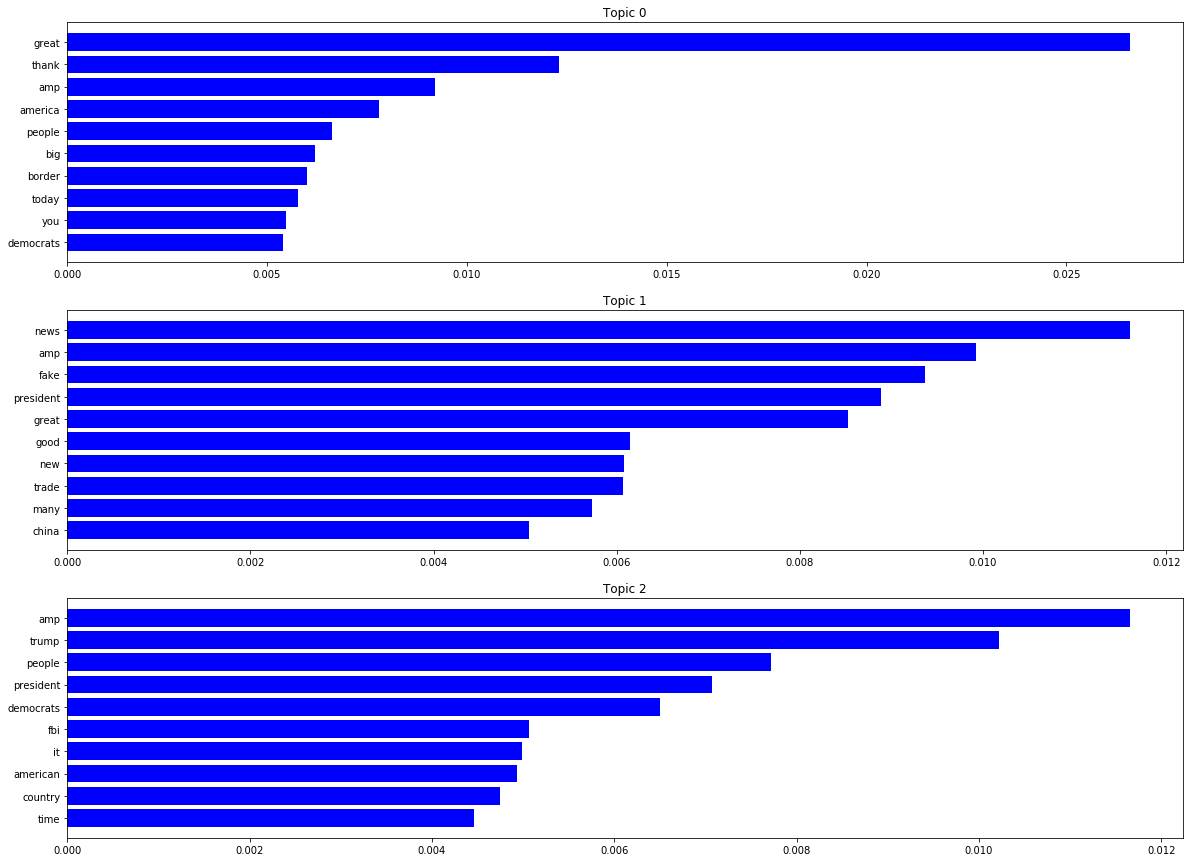

In [193]:
# choice a suitable number of topics
tweets_lda = LdaMulticore(corpus=tweets_corpus, num_topics = 3, id2word = tweets_dictionary, passes=10,workers=num_cores-1)
top_words = [[word for word,_ in tweets_lda.show_topic(topic_id, topn=10)] for topic_id in range(tweets_lda.num_topics)]
top_betas = [[beta for _,beta in tweets_lda.show_topic(topic_id, topn=10)] for topic_id in range(tweets_lda.num_topics)]
top_words
plt.figure(figsize=(20,15))
for i in range(3):
    ax = plt.subplot(3,1,i+1)
    plt.barh(range(10), top_betas[i][:10], align='center',color='blue', ecolor='black')
    ax.invert_yaxis()
    ax.set_yticks(range(10))
    ax.set_yticklabels(top_words[i][:10])
    plt.title("Topic "+str(i))

Visualise the change of trumps twitter topics over years

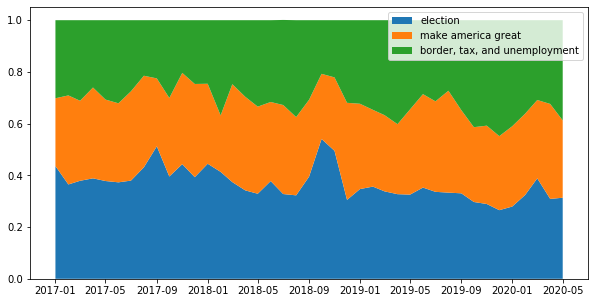

In [197]:
#create time series of topics
topic_distribution = [[i[1] for i in tweets_lda.get_document_topics(tweet)] for tweet in tweets_corpus]
df_topics = pd.DataFrame(topic_distribution,index=df_tweets_clean.created_at,columns=['topic1','topic2','topic3'])
df_topics = df_topics.reset_index().rename(columns={'created_at':'Date'})
df_topics['Date'] = df_topics.Date.dt.strftime('%Y-%m')
df_topics = df_topics.groupby('Date').mean()
plt.figure(figsize=(10,5))
plt.stackplot(pd.to_datetime(df_topics.index),df_topics.iloc[:,0],df_topics.iloc[:,1],df_topics.iloc[:,2],labels=['election','make america great','border, tax, and unemployment'])

plt.legend()
plt.show()

## 3.2 LSA Methods demonstration

In [ ]:
#import modules
from gensim.models import LsiModel
'''
Create an LSA model using Gensim
After corpus creation, you can generate a model using LSA.
'''
def create_gensim_lsa_model(doc_clean,number_of_topics,words):
    """
    Input  : clean document, number of topics and number of words associated with each topic
    Purpose: create LSA model using gensim
    Output : return LSA model
    """
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    # generate LSA model
    lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    return lsamodel

'''
Determine the number of topics
Another extra step needs to be taken to optimize results by identifying an optimum amount of topics. Here, you will generate coherence scores to determine an optimum number of topics.
'''
'''Let's plot coherence score values.'''

def plot_graph(doc_clean,start, stop, step):
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix,doc_clean,
                                                            stop, start, step)
    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

'''
# LSA Model
number_of_topics=7
words=10
document_list,titles=load_data("","articles.txt")
clean_text = preprocess_data(document_list)
model = create_gensim_lsa_model(clean_text,number_of_topics,words)
'''

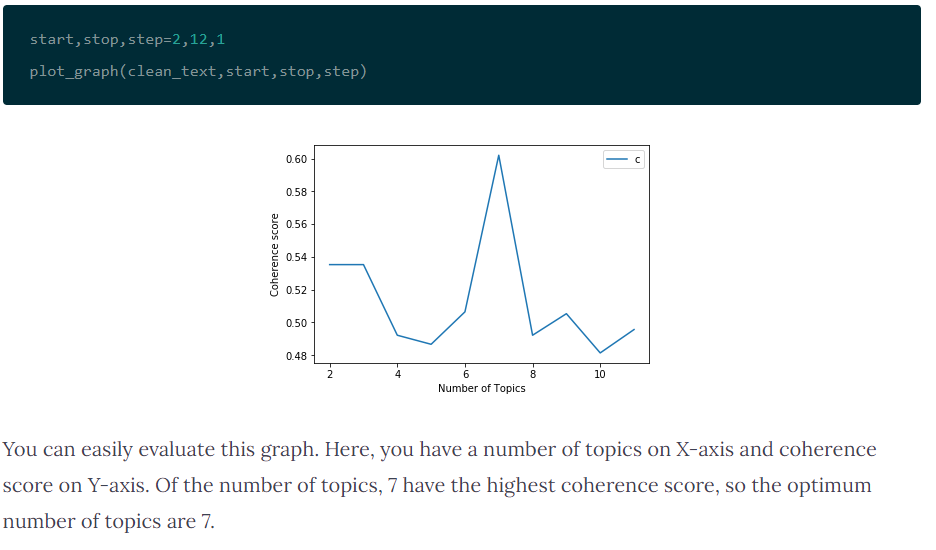

## 3.3 doc2vec method demonstration

In [13]:
#Import all the dependencies
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [27]:
data = ["I love machine learning. Its awesome.",
        "I love coding in python",
        "I love building chatbots",
        "they chat amagingly well"]
labels = ['a','b','c','d']
tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[labels[i]]) for i, _d in enumerate(data)]

In [ ]:
max_epochs = 100
vec_size = 20
alpha = 0.025

model = Doc2Vec(size=vec_size,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=1,
                dm =1)
  
model.build_vocab(tagged_data)

for epoch in range(max_epochs):
    print('iteration {0}'.format(epoch))
    model.train(tagged_data,
                total_examples=model.corpus_count,
                epochs=model.iter)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha

model.save("d2v.model")
print("Model Saved")

In [33]:
tagged_data

[TaggedDocument(words=['i', 'love', 'machine', 'learning', '.', 'its', 'awesome', '.'], tags=['a']),
 TaggedDocument(words=['i', 'love', 'coding', 'in', 'python'], tags=['b']),
 TaggedDocument(words=['i', 'love', 'building', 'chatbots'], tags=['c']),
 TaggedDocument(words=['they', 'chat', 'amagingly', 'well'], tags=['d'])]

In [32]:
from gensim.models.doc2vec import Doc2Vec

model= Doc2Vec.load("d2v.model")
#to find the vector of a document which is not in training data
test_data = word_tokenize("I love chatbots".lower())
v1 = model.infer_vector(test_data)
print("V1_infer", v1)

# to find most similar doc using tags
similar_doc = model.docvecs.most_similar('a')
print(similar_doc)


# to find vector of doc in training data using tags or in other words, printing the vector of document at index 1 in training data
len(model.docvecs['a'])

V1_infer [-0.00148195 -0.02881094  0.01341179  0.00337434 -0.01466267 -0.00627068
 -0.0184841   0.01297757 -0.00672576 -0.00769952  0.00375376 -0.00874239
 -0.00839798  0.01712251  0.03110898 -0.00254906 -0.01015988 -0.02308262
 -0.01017983  0.0121725 ]
[('b', 0.9874845743179321), ('d', 0.9869570732116699), ('c', 0.9845460653305054)]


20

---
---
# Section 4: Dictionary based method
- financial stability (Correa et al., 2017)
- finance (Loughran and McDonald, 2013)
- social media sentiment from Nielsen(2011) and named here as ‘Afinn’ 
- psychological terms (from the Harvard IV psychological dictionary as used in Tetlock (2007))
- common English words that measure a score between the emotions of anxiety and excitement (Nyman et al., 2018)

The purely dictionary based text metrics with positive and negative words which we use are from
- Nyman et al. (2018) “News and narratives in financial systems: exploiting big data for systemic risk assessment.” 
- Loughran and McDonald (2013)
- Nielsen (2011) “A new ANEW: Evaluation of a word list for sentiment analysis in microblogs"
- Hu and Liu (2004) “Mining and summarizing customer reviews.” 
- Hu et al.(2017) “Analyzing Users’ Sentiment Towards Popular Consumer Industries and Brands on Twitter.”
- Correa et al (2017) “Constructing a Dictionary for Financial Stability.”
- Harvard IV psychological dictionary used by Tetlock (2007).

In [91]:
from textblob import TextBlob
def textbolb_score(text):
    return TextBlob(text).sentiment.polarity
news_headline.loc[:,'TextBolb Score'] = news_headline['Text'].apply(textbolb_score)


,Sentiment,Text,Cleaned_text,TextBolb Score
0,neutral,"According to Gran , the company has no plans t...","[accord, gran, compani, plan, move, product, r...",0.000000
1,neutral,Technopolis plans to develop in stages an area...,"[technopoli, plan, develop, stage, area, le, 1...",0.083333
2,negative,The international electronic industry company ...,"[intern, electron, industri, compani, elcoteq,...",0.000000
3,positive,With the new production plant the company woul...,"[new, product, plant, compani, would, increas,...",-0.064802
4,positive,According to the company 's updated strategy f...,"[accord, compani, updat, strategi, year, 2009,...",0.000000
...,...,...,...,...
4841,negative,LONDON MarketWatch -- Share prices ended lower...,"[london, marketwatch, share, price, end, lower...",-0.500000
4842,neutral,Rinkuskiai 's beer sales fell by 6.5 per cent ...,"[rinkuskiai, beer, sale, fell, 6, 5, per, cent...",0.000000
4843,negative,Operating profit fell to EUR 35.4 mn from EUR ...,"[oper, profit, fell, eur, 35, 4, mn, eur, 68, ...",0.000000
4844,negative,Net sales of the Paper segment decreased to EU...,"[net, sale, paper, segment, decreas, eur, 221,...",0.040000


In [105]:
mcdonald_dict = pd.read_excel('inquirerbasic.xls')
mcdonald_dict.columns

Index(['Entry', 'Source', 'Positiv', 'Negativ', 'Pstv', 'Affil', 'Ngtv',
       'Hostile', 'Strong', 'Power',
       ...
       'Anomie', 'NegAff', 'PosAff', 'SureLw', 'If', 'NotLw', 'TimeSpc',
       'FormLw', 'Othtags', 'Defined'],
      dtype='object', length=186)

In [181]:
all_negative = mcdonald_dict.dropna(subset=['Negativ']).reset_index(drop=True)
econ_negative = mcdonald_dict.dropna(subset=['Negativ','Econ@']).reset_index(drop=True)
econ_negative = [lemma.lemmatize(p_stemmer.stem(str(i))) for i in econ_negative.Entry]
all_negative = [lemma.lemmatize(p_stemmer.stem(str(i))) for i in all_negative.Entry]

def score_econ(text):
    return sum([(i in econ_negative) for i in text])
def score_all(text):
    return sum([(i in all_negative) for i in text])
news_headline.loc[:,'Econ Score'] = news_headline['Cleaned_text'].apply(score_econ)
news_headline.iloc[:,[0,4]].groupby('Sentiment').mean()

,Econ Score
Sentiment,
negative,0.014901
neutral,0.010768
positive,0.005869


In [186]:
news_headline.loc[:,'All Score'] = news_headline['Cleaned_text'].apply(score_all)
news_headline.iloc[:,[0,4,5]].groupby('Sentiment').mean()

,Econ Score,All Score
Sentiment,,
negative,0.014901,0.422185
neutral,0.010768,0.161514
positive,0.005869,0.195891


This is the reason why semi supervised learning is necessary

In [204]:
for n,i in enumerate(econ_clean):
    print(economical_doc[n],end=' ')
    print(score_all(i))

The repo rate path that provides the basis for the forecasts in the draft Monetary Policy Report assumes continued rate rises during the forecast period, but at a slower pace compared to February. A slight postponement of the next rise feels natural in light of the somewhat lower inflation forecast, especially this year. 1
Developments since April have been largely as we expected, and it is now proposed that the repo-rate path is held unchanged, with slow increases in the repo rate during the forecast period. 0
The very expansionary monetary policy was never intended to last forever. Now when inflation is around 2 per cent, monetary policy is slowly going in a less expansionary direction, with a rate rise late last year, and another late this year or early next year. 1
The forecast means that the monetary policy plan remains the same in the near term, with one rate rise most probably in December. 0


____
____
# Section 5: word vectorisation
I would suggest a semi-supervised method on enlarging the dictionary size. For ther dictionary we have, I would use word2vec/Bert to vectorise the word and use clustering to find the most similar words and enlarge our dictioanry size. And include those into our dictionary-based sentiment system.

In [160]:
from gensim.models import Word2Vec

word2vec = Word2Vec(news_headline['Cleaned_text'], min_count=2)

In [180]:
vocabulary = word2vec.wv.vocab
sim_words = word2vec.wv.most_similar('liquid')
sim_words

[('group', 0.9997225999832153),
 ('medium', 0.9997035264968872),
 ('major', 0.9997035264968872),
 ('hous', 0.9996931552886963),
 ('ceo', 0.999686598777771),
 ('line', 0.9996844530105591),
 ('project', 0.9996836185455322),
 ('say', 0.999681830406189),
 ('acquir', 0.999680757522583),
 ('give', 0.9996806383132935)]

In [172]:
econ_negative

['bankrupt',
 'bankruptci',
 'beggar',
 'blackmail',
 'bribe',
 'broke#3',
 'bum',
 'cheap',
 'common',
 'corrupt',
 'cost#1',
 'cost#2',
 'costli',
 'costli',
 'debtor',
 'default',
 'deficit',
 'depreci',
 'depression#2',
 'destitut',
 'expense#1',
 'expens',
 'extravag',
 'fine#6',
 'fine#7',
 'fire#2',
 'gamble#1',
 'gamble#2',
 'hole#2',
 'hustl',
 'hustler',
 'inflat',
 'jobless',
 'laid#2',
 'lay#3',
 'liquid',
 'liquid',
 'miser',
 'owe',
 'poor#2',
 'poor#3',
 'poor#4',
 'poverti',
 'recess',
 'squander',
 'tariff',
 'underworld',
 'uneconom',
 'unemploy',
 'unprofit',
 'vagabond',
 'vagrant',
 'waste#1',
 'waste#2']

---
---
---
# Appendix:

**Possible benchmarks**
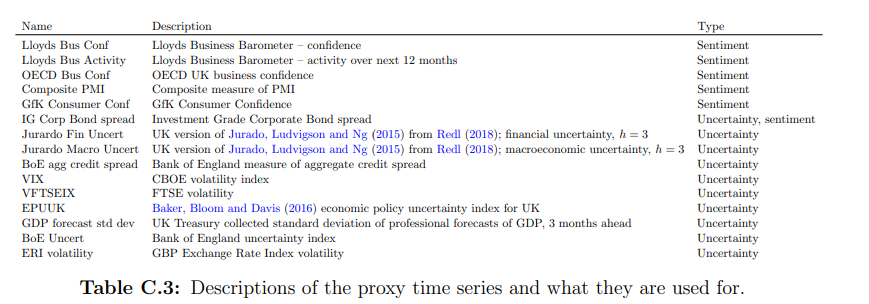

# Some other failed practice

In [34]:
from newsapi import NewsApiClient
api = NewsApiClient(api_key='42da8fda9b904d31937b231d6ea4661c')
api.get_everything(q='unemployment',from_param='2020-05-24',to='2020-04-24',sort_by='popularity',language='en',page=5)

{'status': 'ok',
 'totalResults': 31643,
 'articles': [{'source': {'id': 'cnn', 'name': 'CNN'},
   'author': 'Caitlin Hu, CNN',
   'title': "Can the world's oldest profession survive the age of social distancing?",
   'description': "Don't kiss. Tell clients to wash their hands before they touch you. Wear a mask. Avoid face-to-face positions. And even: Put on a nurse costume and pull out a thermometer -- if his temperature is normal, make it part of the game. If he has a fever, end the se…",
   'url': 'https://www.cnn.com/2020/05/24/us/sex-workers-coronavirus-intl/index.html',
   'urlToImage': 'https://cdn.cnn.com/cnnnext/dam/assets/200524130233-01-red-light-district-coronavirus-super-tease.jpg',
   'publishedAt': '2020-05-24T18:06:45Z',
   'content': "Several sex workers interviewed for this story spoke on condition of anonymity due to fear of legal repercussion and social stigma. \r\n (CNN)Don't kiss. Tell clients to wash their hands before they to… [+16783 chars]"},
  {'source': {'i

In [36]:
import tweepy

# Authenticate to Twitter
auth = tweepy.OAuthHandler("VaK2tSqN63St7e9iYZFIrulwq", "EPh8SWTxdmnANJFjnGr4tnXpPbdYstMoYOkPwbbpp6ezr3N0Nf")
auth.set_access_token("1264951142557114373-fdltg5uwK8neEkmzsBiZGJFvqD67NI","DK5EQEoxplyWZ2EC0x3dqbpdUSXTtjJNrZLYZYeU7TlML")
api = tweepy.API(auth)
# test authentication
try:
    api.verify_credentials()
    print("Authentication OK")
except:
    print("Error during authentication")

Authentication OK


In [67]:
data1 = api.user_timeline(id='@realDonaldTrump', count=1000)

In [68]:
tweets = [[tweet._json['created_at'],tweet._json['text']] for tweet in data1]
pd.DataFrame(tweets)

,0,1
0,Mon May 25 13:31:53 +0000 2020,"....Hawaii in a big, fully loaded 747, to play..."
1,Mon May 25 13:31:53 +0000 2020,"....3 months and, if I waited 3 years, they wo..."
2,Mon May 25 13:31:52 +0000 2020,Some stories about the fact that in order to g...
3,Mon May 25 13:09:55 +0000 2020,https://t.co/8fvJRDJREz
4,Mon May 25 13:04:39 +0000 2020,https://t.co/U02F9CL0je
...,...,...
195,Wed May 20 04:46:32 +0000 2020,RT @JonathanTurley: The Flynn case is fast bec...
196,Wed May 20 04:37:27 +0000 2020,YES! https://t.co/1QEgo7MdTe
197,Wed May 20 04:33:22 +0000 2020,"A really great woman, and what a job she is do..."
198,Wed May 20 04:26:32 +0000 2020,RT @WSJ: From @WSJopinion: The use of the Fore...


In [69]:
tweets

[['Mon May 25 13:31:53 +0000 2020',
  '....Hawaii in a big, fully loaded 747, to play. What did that do to the so-called Carbon Footprint? He also played… https://t.co/70jeGA4Lnq'],
 ['Mon May 25 13:31:53 +0000 2020',
  '....3 months and, if I waited 3 years, they would do their usual “hit” pieces anyway. They are sick with hatred and… https://t.co/Iwgr16dS0n'],
 ['Mon May 25 13:31:52 +0000 2020',
  'Some stories about the fact that in order to get outside and perhaps, even a little exercise, I played golf over th… https://t.co/yEli8hOQYA'],
 ['Mon May 25 13:09:55 +0000 2020', 'https://t.co/8fvJRDJREz'],
 ['Mon May 25 13:04:39 +0000 2020', 'https://t.co/U02F9CL0je'],
 ['Mon May 25 12:19:30 +0000 2020',
  'RT @realDonaldTrump: MAKE AMERICA GREAT AGAIN!'],
 ['Mon May 25 12:19:24 +0000 2020', 'RT @realDonaldTrump: OBAMAGATE!'],
 ['Mon May 25 12:18:36 +0000 2020',
  'TRANSITION TO GREATNESS! Get ready, it is already happening again!'],
 ['Mon May 25 12:16:20 +0000 2020', 'HAPPY MEMORIAL DA